
@author : Romy (July 2022)

Useful Ressources : 
- https://nbviewer.org/github/NeuroanatomyAndConnectivity/gradient_analysis/blob/master/04_visualize_networks.ipynb
- https://github.com/MICA-MNI/BrainStat/blob/master/brainstat/context/resting.py

In [1]:
%matplotlib inline 

# !git clone https://github.com/margulies/gradient_analysis

import h5py, sys, io, os, numpy as np
import nibabel as nib
import nibabel.gifti
import nilearn
from nilearn import datasets, plotting,surface
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'

from brainspace.datasets import load_group_fc, load_parcellation, load_conte69



sys.path.append('/home/romy.beaute/projects/hypnomed/')
from helpers import imageCrop,load_embmat
# from helpers import *

In [2]:
templates_path = '/home/romy.beaute/projects/hypnomed/data/template' #path to cortex and yeo templates

output_path = '/home/romy.beaute/projects/hypnomed/analysis/scripts_stats/figures/yeo_networks/' #path to save figures

yeo_infos = pd.read_csv('/home/romy.beaute/projects/hypnomed/data/yeo_infos/7NetworksOrderedNames.csv',delimiter=',')
networks_labels = list(yeo_infos[' Network Name'])

colors = ['purple','blue','green','violet','cream','orange','red']
yeo_infos['colors']=colors 

yeo_infos

,Network Order,Network Name,colors
0,1,Visual,purple
1,2,Somatomotor,blue
2,3,Dorsal Attention,green
3,4,Salience / Ventral Attention,violet
4,5,Limbic,cream
5,6,Control,orange
6,7,Default,red


### Load fsaverage surfaces : cortical and yeo networks

In [3]:


#  CORTICAL SURFACES : Load Freesurfer fsaverage surface with read_label : return array with indices of vertices included in label
lab_lh = nib.freesurfer.read_label(templates_path+'/lh.cortex.label') #shape = (9361,)
lab_rh = 10242 + nib.freesurfer.read_label(templates_path+'/rh.cortex.label') #shape = (9361,)
lab= np.concatenate((lab_lh,lab_rh))
print('- Cortical shape : ',lab.shape)

# YEO NETWORKS SURFACES FROM FREESURFER
freesurfer_yeo_path = '/home/romy.beaute/projects/hypnomed/data/template/fsaverage/label'

yeo_l = surface.load_surf_data(os.path.join(freesurfer_yeo_path,'lh.Yeo2011_7Networks_N1000.annot'))
yeo_r = surface.load_surf_data(os.path.join(freesurfer_yeo_path,'rh.Yeo2011_7Networks_N1000.annot'))
yeo_freesurfer = np.hstack([yeo_l,yeo_r])
print('- Yeo surface shape : ',yeo_freesurfer.shape)

yeo7_freesurfer = np.concatenate((yeo_l[lab_lh], yeo_r[lab_rh]))
print('- Yeo (freesurfer) surface shape, after cortical mask : ',yeo7_freesurfer.shape)


- Cortical shape :  (18715,)
- Yeo surface shape :  (327684,)
- Yeo (freesurfer) surface shape, after cortical mask :  (18715,)


### Load pheno data

In [4]:
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_design_matrix


# hypnomed_csv = pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/hypnomed.csv')
hypnomed_csv = pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/questionnaires_hypnomed.csv')
hypnomed_csv_withoutliers = hypnomed_csv.query('outlier == 0')
hypnomed_csv_G1 = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']=='G1']
hypnomed_csv_G2 = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']=='G2']


sublist_hypnomed = hypnomed_csv.query('outlier == 0')['sub_id'].tolist()
sublist_hypnomed_G1 = hypnomed_csv_G1['sub_id'].tolist()
sublist_hypnomed_G2 = hypnomed_csv_G2['sub_id'].tolist()
print('n = {} subjects in G1 / n = {} subjects in G2'.format(len(sublist_hypnomed_G1),len(sublist_hypnomed_G2)))



n_subjects = len(sublist_hypnomed) 
print('n subjects = ',n_subjects)
emb_sample = sublist_hypnomed #before dividing by groups

labels = np.concatenate([([i]*n_subjects) for i in ['control','meditation','hypnosis']],axis=0)
subjects = emb_sample*3
sub_groups = hypnomed_csv_withoutliers['group'].tolist()*3
sub_ids = hypnomed_csv_withoutliers['id'].tolist()*3

behavioral_hypnomed = pd.DataFrame(data={'sub_ids':sub_ids,'subjects':subjects,'labels':labels,'group':sub_groups})
behavioral_hypnomed

n = 18 subjects in G1 / n = 18 subjects in G2
n subjects =  36


,sub_ids,subjects,labels,group
0,1,sub-01,control,G2
1,2,sub-02,control,G1
2,3,sub-03,control,G1
3,4,sub-04,control,G1
4,5,sub-05,control,G2
...,...,...,...,...
103,35,sub-35,hypnosis,G2
104,36,sub-36,hypnosis,G1
105,37,sub-37,hypnosis,G2
106,38,sub-38,hypnosis,G2


###  Recreate the embedding design (data visualisation purpose)

We recall that the order of the "meta" embedding matrix* (grouping the different matrices for each block, for each participant) has been rearranged so as to display the embedding for each subject in the following order: "control", "meditation", "hypnosis", regardless of whether the subject did the "meditation" condition before or after the "hypnosis" condition (i.e. in block 2 or 3). The rearrangement is represented in the following design matrix : 

**matrix stored in : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat*

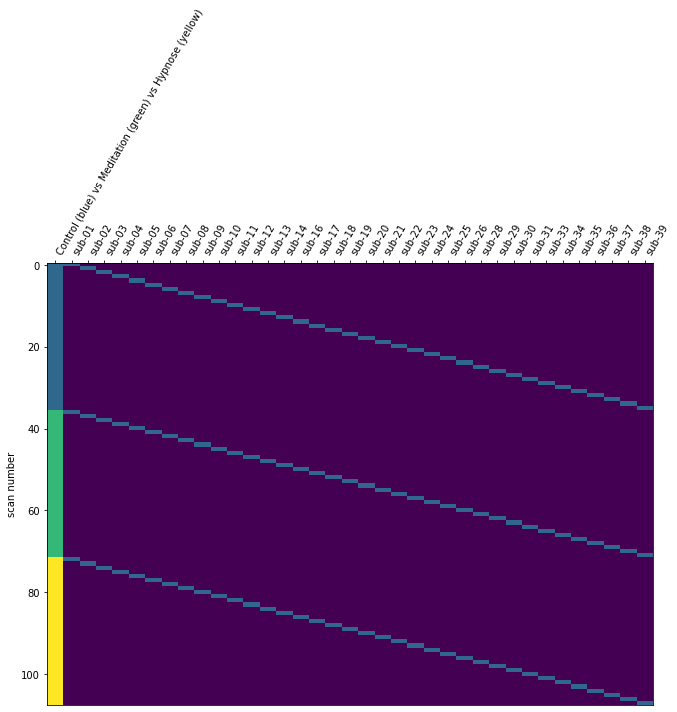

In [5]:
#Triple effect : control vs meditation vs hypnose

condition_effect_triple = np.hstack(([1] * n_subjects, [2] * n_subjects, [3] * n_subjects))
subject_effect_triple = np.vstack((np.eye(n_subjects), np.eye(n_subjects),np.eye(n_subjects)))
paired_design_matrix_triple = pd.DataFrame(
    np.hstack((condition_effect_triple[:, np.newaxis], subject_effect_triple)),
    columns=['Control (blue) vs Meditation (green) vs Hypnose (yellow)'] + emb_sample)


#_, (ax_paired) = plt.subplots(1,1, gridspec_kw={'width_ratios': [1, 17]})
plot_design_matrix(paired_design_matrix_triple, rescale=False)#, ax=ax_paired)
# ax_paired.set_title('paired design', fontsize=12)
# plt.set_title('paired design', fontsize=12)
plt.tight_layout()
plotting.show()

Therefore, we can conduct the analysis group by group to make sure that we are not looking at a block effet on the gradients.

In [7]:
import re

embmat_path = '/home/romy.beaute/projects/hypnomed/data/emb_matrices'
matfile = 'control_meditation_hypnose'


outliers_indxs = [15,27,32,40]
outliers_indxs_hyp = [15,27,39]



def get_updated_embeddings(selected_group):

    '''
    Return the embedding of for the 3 conditions separately, for a chosen block group (or for all)
    exclude_group : 
    - 'G1' : control/meditation/hypnose
    - 'G2' : control/hypnose/meditation
    - None : both group mixed
    '''
    hypnomed_data = hypnomed_csv_withoutliers
    exclude_group = None if not selected_group else 'G2' if selected_group == 'G1' else 'G1'

    all_outliers = outliers_indxs

    if selected_group:
        print('Keeping only {} (meditation in block {})'.format(selected_group,1+int(re.search(r"\d{1}",selected_group)[0])))
        hypnomed_data = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']==selected_group]
        outliers_group = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']==exclude_group]
        outliers_indxs_group = outliers_group['id'].tolist()
        outliers_subjs_group = outliers_group['sub_id'].tolist()

        #Outliers pour les conditions control and meditation
        all_outliers = np.unique(outliers_indxs_group+outliers_indxs).tolist()
        

    hypnomed_indxs_sublist = hypnomed_data['id'].tolist()
    hypnomed_subjs_sublist = hypnomed_data['sub_id'].tolist()


    outliers_indxs_reshaped = [x-1 for x in all_outliers]

    

    #/!\ Subject 32 missing for condition hypnose : tout les indexes se décallent à partir de l'index 31
    outliers_indxs_reshaped_hypnosis = [x-1 for x in all_outliers if x<32]+[x-2 for x in all_outliers if x>32]

    # print(len(outliers_indxs_reshaped_hypnosis),len(outliers_indxs_reshaped))

    b,b_emb = load_embmat(embmat_path+'/group_{}_embedding.mat'.format(matfile),show_infos=True)


    emb_con = np.delete(b_emb[:40],outliers_indxs_reshaped,0)
    emb_med = np.delete(b_emb[40:80],outliers_indxs_reshaped,0)
    emb_hyp = np.delete(b_emb[80:],outliers_indxs_reshaped_hypnosis,0)

    print('Exclusion following subjects : ', [b['subs'][i] for i in outliers_indxs_reshaped])

    print('Embedding shapes for the different states :\n - Embedding control : {}\n - Embedding meditation : {}\n - Embedding hypnosis : {}'.format(emb_con.shape,emb_med.shape,emb_hyp.shape))
    embeddings = {
        'control':emb_con,
        'meditation':emb_med,
        'hypnose':emb_hyp
        }

    emb_allstates = np.vstack([emb_con,emb_med,emb_hyp]) #embedding with all 3 states conditions
    # print(emb_allstates.shape) #control shape of the global embedding


    emb_sublist = np.delete(b['subs'],[x-1 for x in outliers_indxs])
    print('Redefining subject list after outlier removal : n_subjects = {} --> n_subjects = {}'.format(len(b['subs']),len(emb_sublist )))

    return embeddings,all_outliers

In [9]:
from PIL import Image
from IPython.display import Image as im



def plot_gradients_yeo(condition,group=None):

    embeddings,_ = get_updated_embeddings(selected_group=group)
    print('Embedding shape for {} condition : {}'.format(condition,embeddings[condition].shape))

    print('Selected group : ',group)
    exclude_group = None if not group else 'G2' if group == 'G1' else 'G1'

    a = np.zeros(20484)
    a[lab]=np.mean(embeddings[condition],axis=0)#average across subjects
    emb = a[lab]

    yeo7 = yeo7_freesurfer


    uniqueY = np.array(np.unique(yeo7), dtype=np.int32)[1::]
    sz = len(uniqueY) #7 (corresponds to length network)
    rsns={}
    for c in range(sz): #creates dictionnary
        rsns['k'+str(int(c)+1)]=[]

    r = []     

    for x in range(sz):
        # g = emb[np.where(yeo7 == uniqueY[x]),0]
        g = emb[np.where(yeo7 == uniqueY[x])]
        # for y in g[0]:
        for y in g:
            if y != 0:
                rsns['k'+str(int(x)+1)].append(float(y))
        r.append(np.mean(rsns['k'+str(int(x)+1)]))

    ord = np.argsort(r)

    plot_list=[]
    for c in range(sz):    
        plot_list+=[np.squeeze(rsns['k'+str(ord[c]+1)])]

    names=[]
    for c in range(sz):
        names.append(str(int(ord[c])+1))


#     # convertYeo7 = [2,5,6,0,4,1,3] 
    convertYeo7 = [0,1,2,3,4,5,6]
    # print(convertYeo7)

    cols7 = ((255,255,255),
            (120,  18, 134), #purple
            (70 ,130, 180), #blue
            ( 0 ,118 , 14), #green
            (196 , 58 ,250), #violet
            (220 ,248 ,164), #cream
            (230, 148,  34), #orange
            (205 , 62,  78 )) #red
    cols = cols7
    cols = np.asarray(cols, dtype=float)/255
    yeoCols = ListedColormap(cols,name='colormapYeo')
    # print(yeoCols)

    colors1 = list()
    for i in range(0,len(ord)):
        colors1.append(tuple(cols[convertYeo7[ord[i]] + 1]))

    height=10
    sns.set_context('notebook', font_scale=1.8)
    sns.axes_style("white")
    sns.set_style("white")
    sns.set_palette(colors1)



    fig = plt.figure(figsize=(20,height))
    ax = sns.boxplot(data=plot_list, saturation=0.5, orient='h', showfliers=False) #flierprops=None)#dict(marker='', markersize=0, 
                                                                                #color="white", markeredgecolor="white"))
    ax.set_yticklabels('')
    ax.set(xlabel='Gradient Values ({})\n n = {} subjects, group = {}'.format(condition,embeddings['control'].shape[0],group))
    # ax.set(ylabel=list(yeo_infos[' Network Name']))
    sns.axes_style("white")
    # sns.axlabel('Gradient Values','', fontsize=22)
    #ax.xlabel('Gradient Values','', fontsize=22)
    # plt.savefig('gradient_data/figures/yeo_dist_plot.pdf')
    # plt.savefig('gradient_data/figures/yeo_dist_plot.png')
    # plt.savefig(output_path+'yeo_dist_plot_{}.pdf'.format(condition))
    if not group:
        group = 'AllGroups'


    plt.savefig(output_path+'yeo_dist_plot_{}_{}.png'.format(condition,group))
    plt.close(fig)

    fig, axarr = plt.subplots(nrows=sz, ncols=1, figsize=(2*(20/sz),height))
    data = datasets.fetch_atlas_yeo_2011(data_dir='gradient_data/templates/')
    yeoV7 = nibabel.load(data.thick_7)
    y = 0

    for x in range(sz):
        yeoV7_1 = nibabel.Nifti1Image((yeoV7.get_fdata() == convertYeo7[ord[x]] + 1).astype(int), yeoV7.affine)     
        yeoCols = ListedColormap(cols[[0,convertYeo7[ord[x]] + 1]],name='colormapYeo')
        plotting.plot_glass_brain(yeoV7_1, axes=axarr[x], annotate=False, alpha=0.3, cmap=yeoCols, threshold=0.1, 
                            output_file=output_path+'yeo_brains_{}_{}.png'.format(condition,group))
        y += 1


    i1 = Image.open(output_path+'yeo_dist_plot_{}_{}.png'.format(condition,group))
    i2 = Image.open(output_path+'yeo_brains_{}_{}.png'.format(condition,group))
    result = Image.new("RGBA", (np.shape(i1)[1]+50, np.shape(i1)[0]))
    result.paste(i1, (120, 0))
    result.paste(i2, (0, 0))
    result.save(output_path+'Yeo7_{}_{}.png'.format(condition,group))
    os.remove(output_path+'yeo_dist_plot_{}_{}.png'.format(condition,group))
    os.remove(output_path+'yeo_brains_{}_{}.png'.format(condition,group))
    # if group:
    #     filename=output_path+'Yeo7_{}_{}.png'.format(condition,group)
    # else:
    #     filename=output_path+'Yeo7_{}.png'.format(condition)

    return im(filename=output_path+'Yeo7_{}_{}.png'.format(condition,group))



### Mean gradients for Control condition

Keeping only G1 (meditation in block 2)
 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-01', 'sub-05', 'sub-08', 'sub-09', 'sub-12', 'sub-15', 'sub-16', 'sub-18', 'sub-21', 'sub-23', 'sub-24', 'sub-25', 'sub-27', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-35', 'sub-37', 'sub-38', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for control condition : (18, 18715)
Selected group :  G1


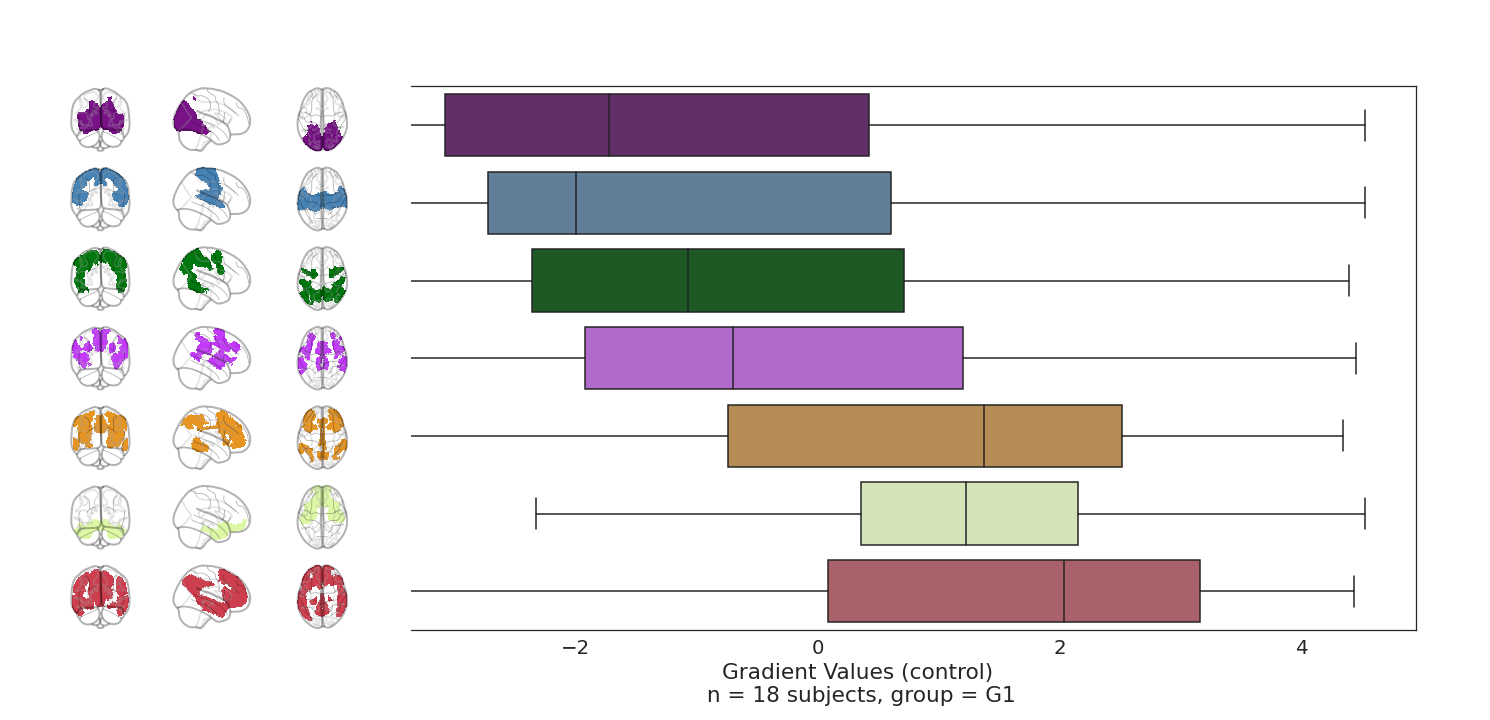

In [10]:
plot_gradients_yeo('control','G1')

Keeping only G2 (meditation in block 3)
 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-10', 'sub-11', 'sub-13', 'sub-14', 'sub-15', 'sub-17', 'sub-19', 'sub-20', 'sub-22', 'sub-26', 'sub-27', 'sub-28', 'sub-32', 'sub-34', 'sub-36', 'sub-39', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for control condition : (18, 18715)
Selected group :  G2


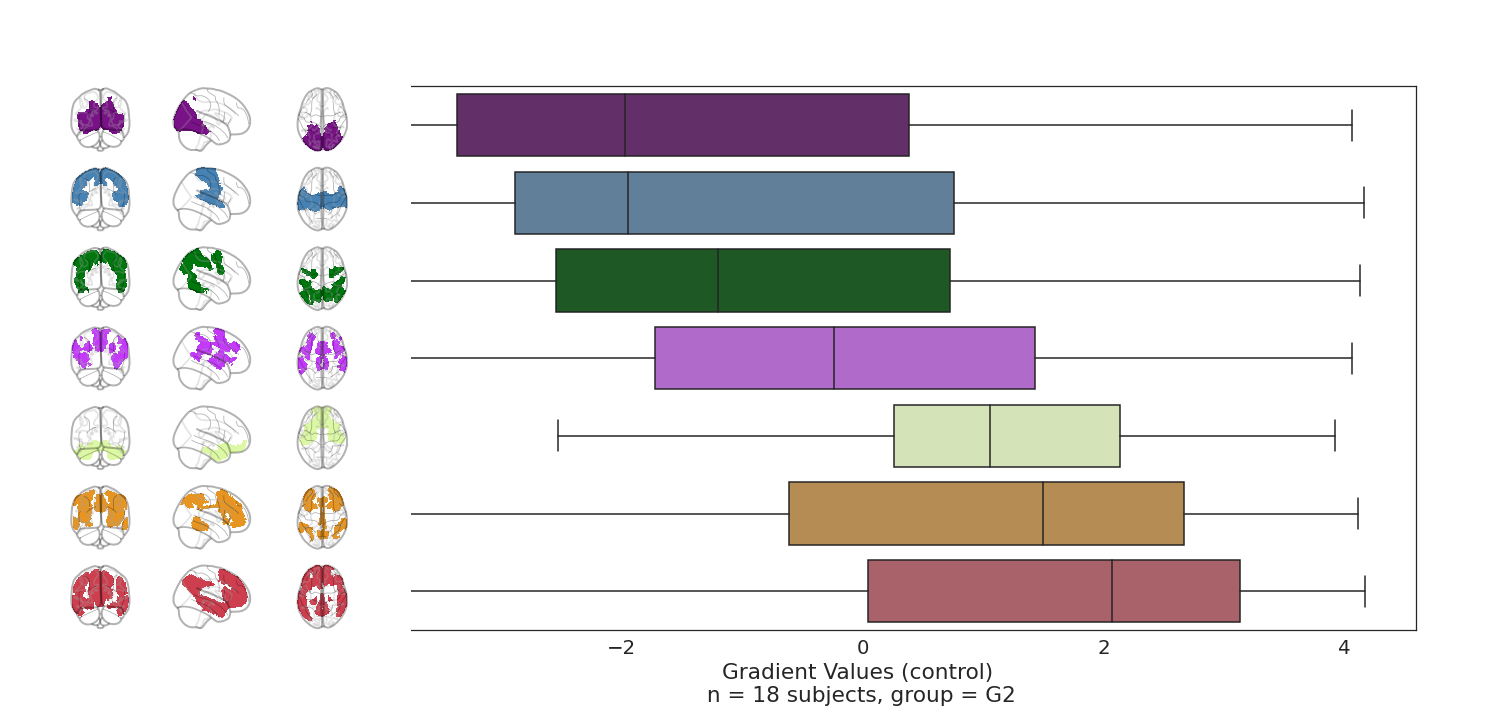

In [11]:
plot_gradients_yeo('control','G2')

 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-15', 'sub-27', 'sub-32', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (36, 18715)
 - Embedding meditation : (36, 18715)
 - Embedding hypnosis : (36, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for control condition : (36, 18715)
Selected group :  None


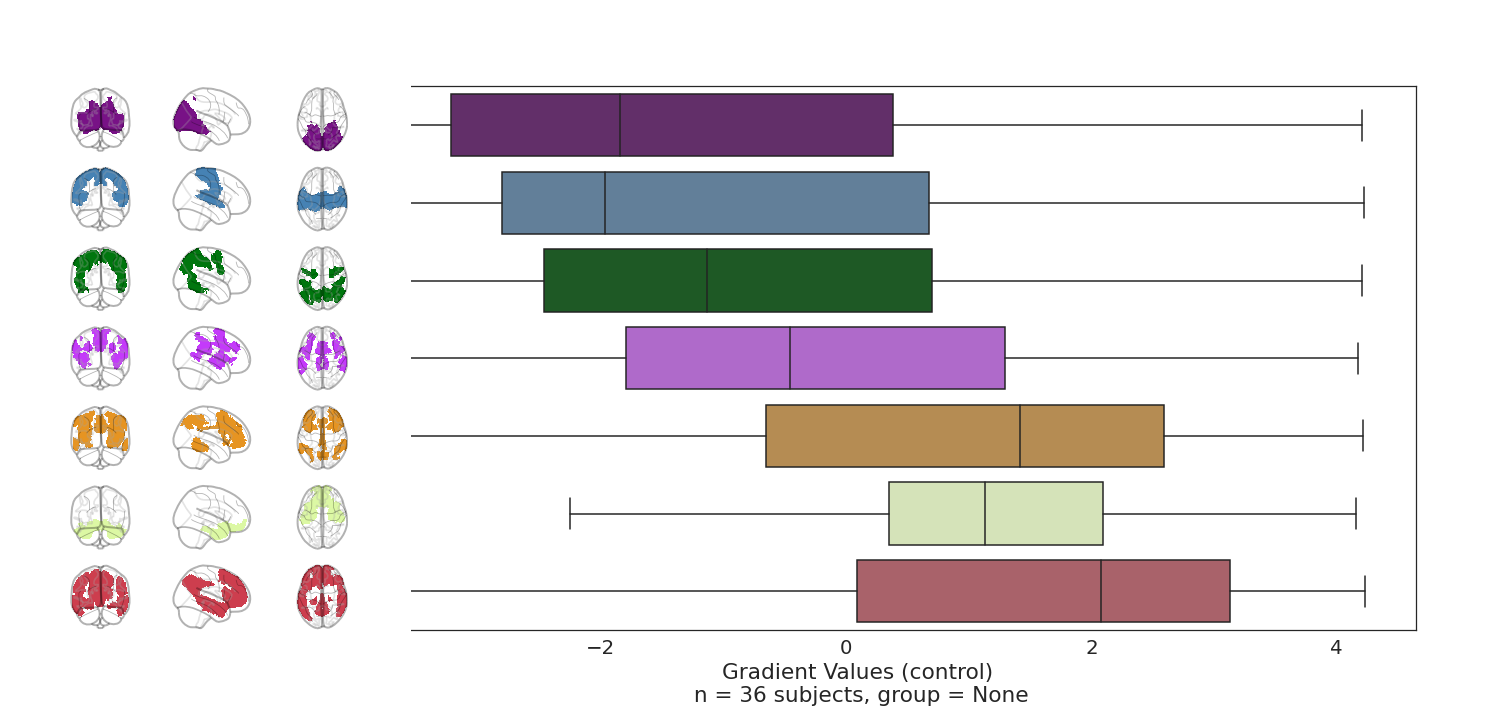

In [12]:
plot_gradients_yeo('control')

### Mean gradients for Meditation condition

Keeping only G1 (meditation in block 2)
 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-01', 'sub-05', 'sub-08', 'sub-09', 'sub-12', 'sub-15', 'sub-16', 'sub-18', 'sub-21', 'sub-23', 'sub-24', 'sub-25', 'sub-27', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-35', 'sub-37', 'sub-38', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for meditation condition : (18, 18715)
Selected group :  G1


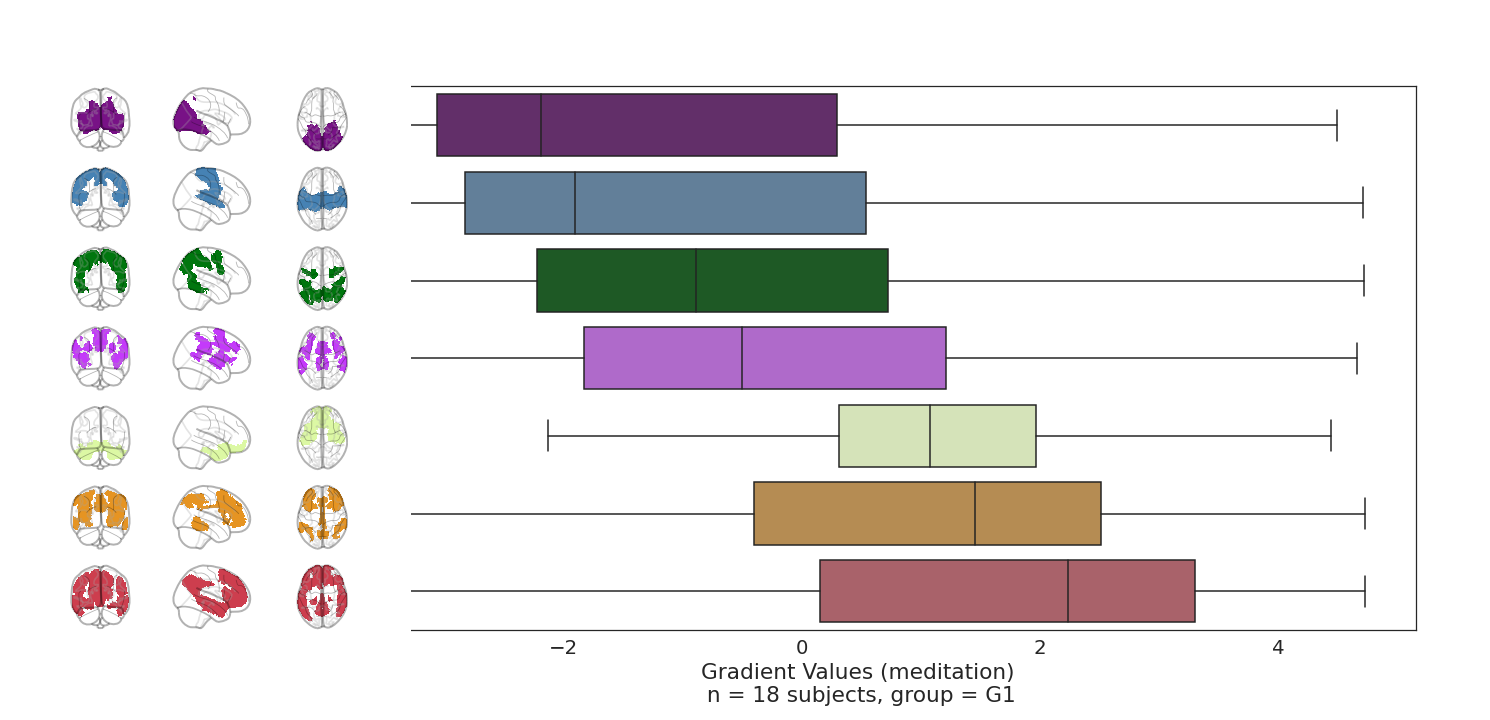

In [13]:
plot_gradients_yeo('meditation','G1')

Keeping only G2 (meditation in block 3)
 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-10', 'sub-11', 'sub-13', 'sub-14', 'sub-15', 'sub-17', 'sub-19', 'sub-20', 'sub-22', 'sub-26', 'sub-27', 'sub-28', 'sub-32', 'sub-34', 'sub-36', 'sub-39', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for meditation condition : (18, 18715)
Selected group :  G2


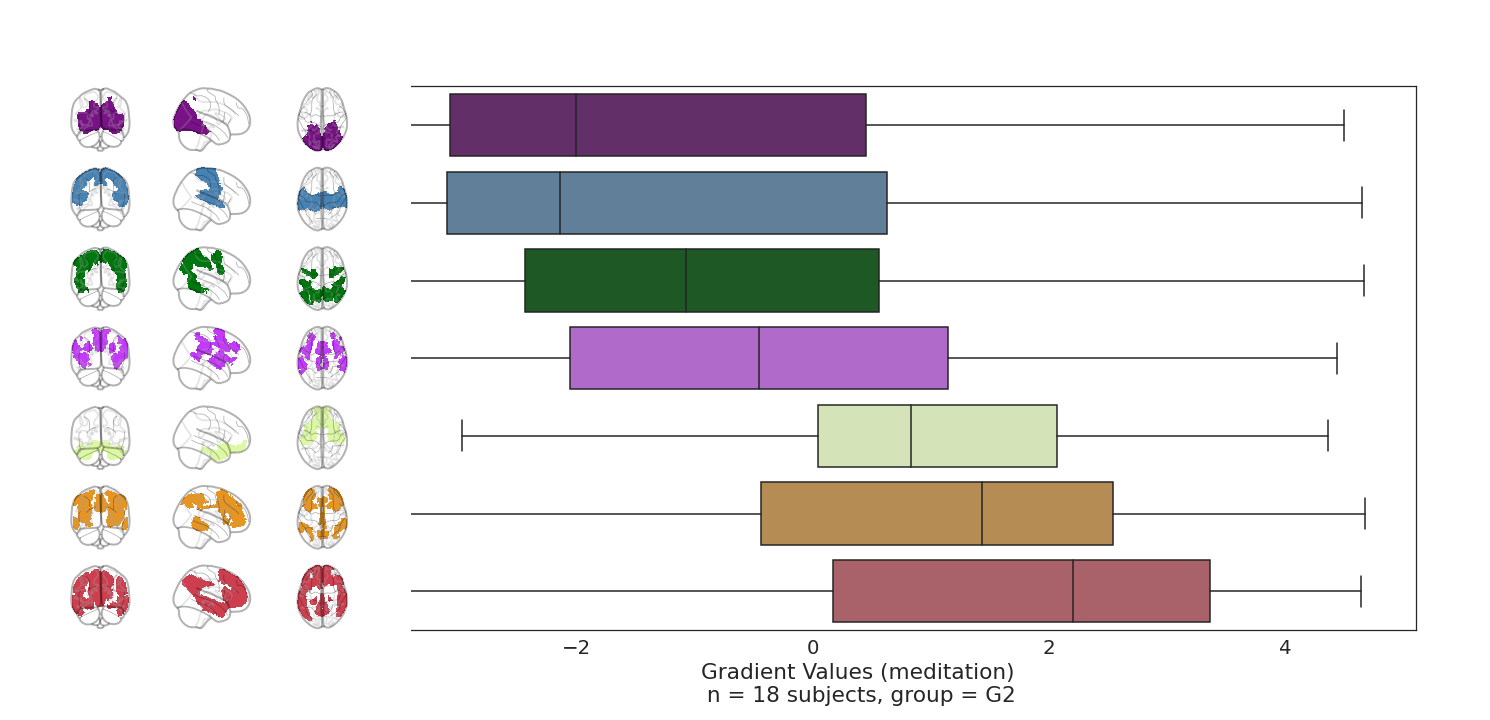

In [14]:
plot_gradients_yeo('meditation','G2')

 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-15', 'sub-27', 'sub-32', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (36, 18715)
 - Embedding meditation : (36, 18715)
 - Embedding hypnosis : (36, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for meditation condition : (36, 18715)
Selected group :  None


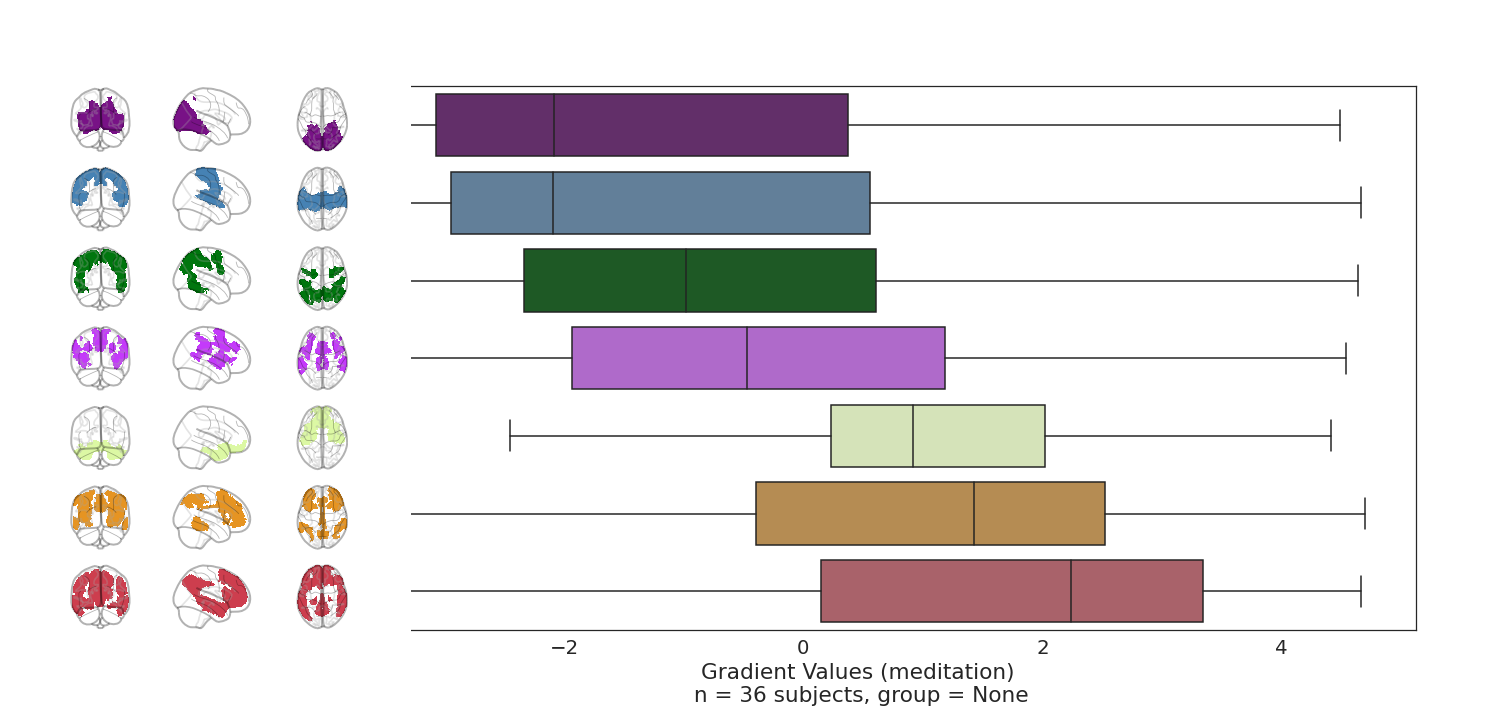

In [15]:
plot_gradients_yeo('meditation')

### Mean gradients for Hypnose condition

Keeping only G1 (meditation in block 2)
 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-01', 'sub-05', 'sub-08', 'sub-09', 'sub-12', 'sub-15', 'sub-16', 'sub-18', 'sub-21', 'sub-23', 'sub-24', 'sub-25', 'sub-27', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-35', 'sub-37', 'sub-38', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for hypnose condition : (18, 18715)
Selected group :  G1


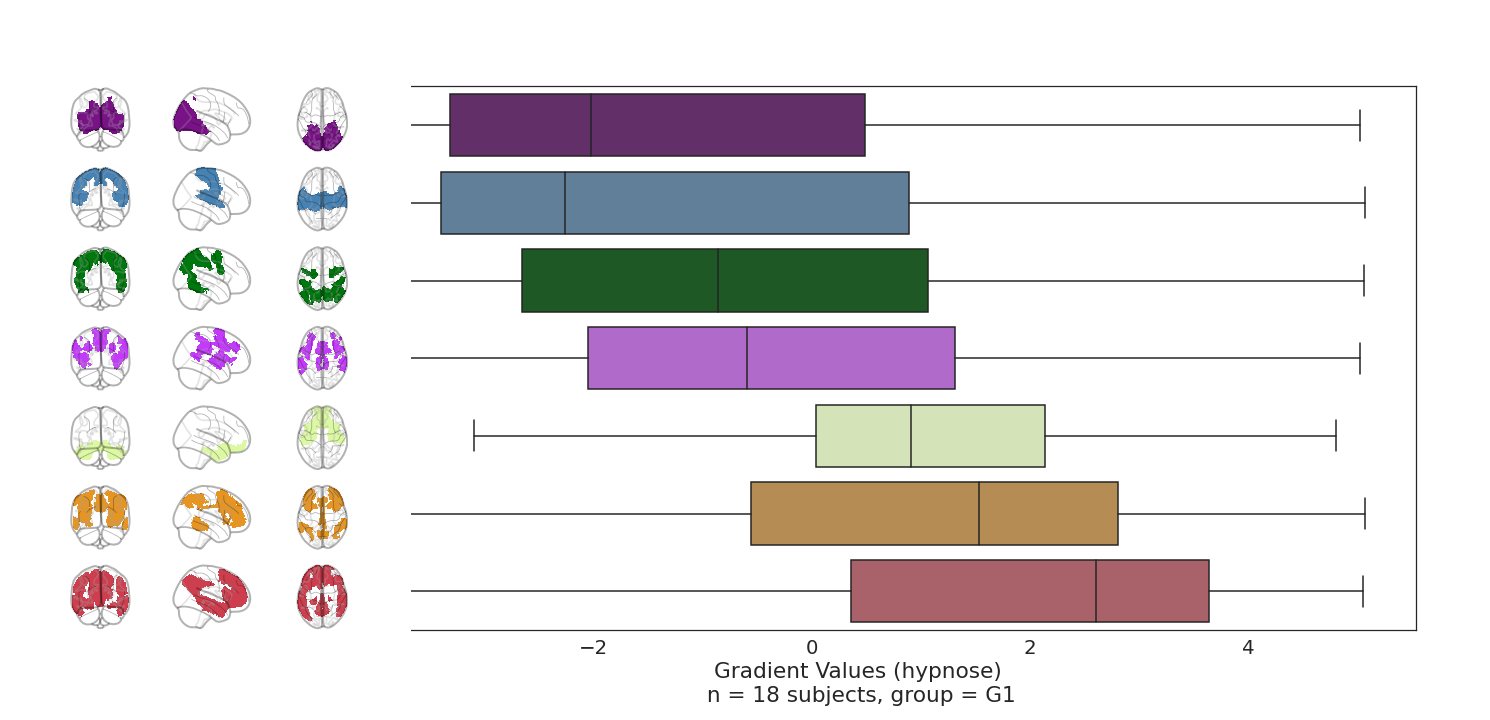

In [16]:
plot_gradients_yeo('hypnose','G1')

Keeping only G2 (meditation in block 3)
 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-10', 'sub-11', 'sub-13', 'sub-14', 'sub-15', 'sub-17', 'sub-19', 'sub-20', 'sub-22', 'sub-26', 'sub-27', 'sub-28', 'sub-32', 'sub-34', 'sub-36', 'sub-39', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for hypnose condition : (18, 18715)
Selected group :  G2


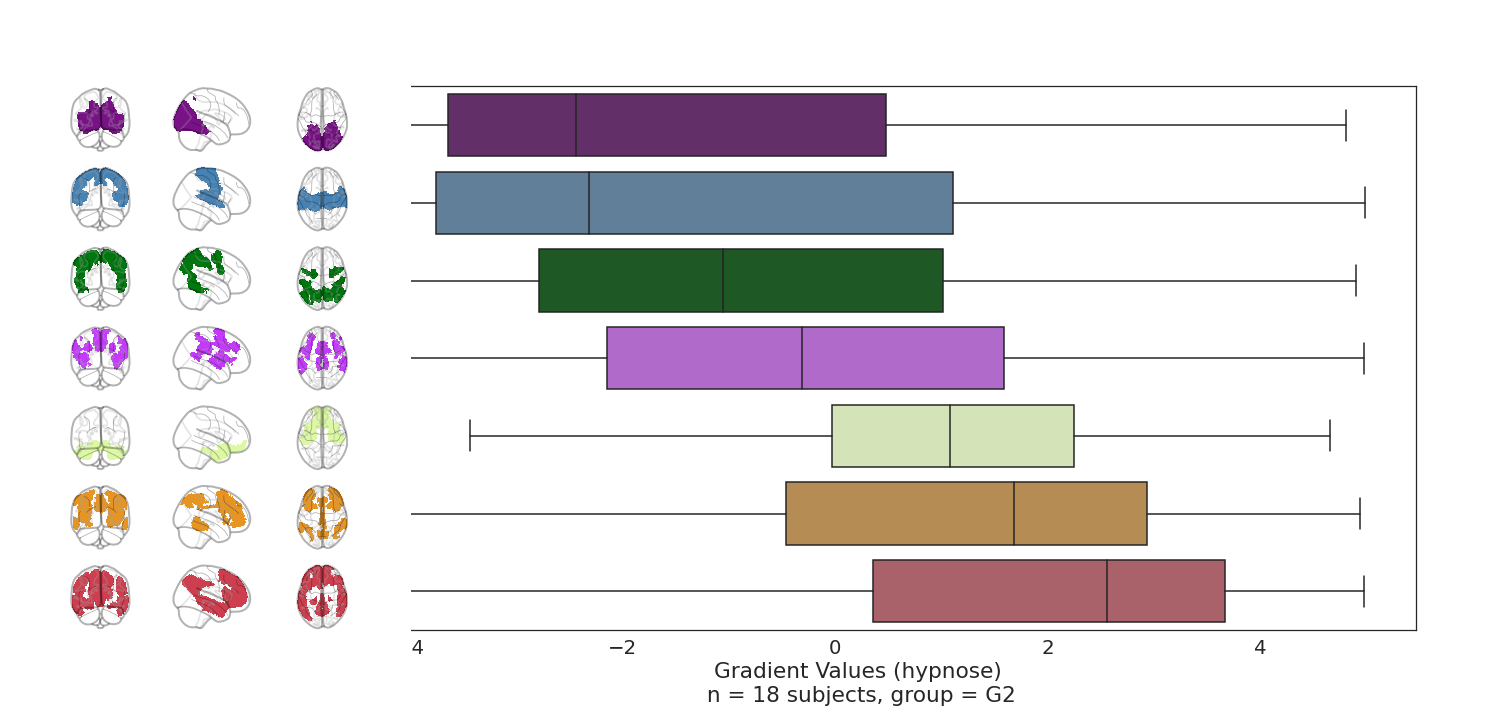

In [17]:
plot_gradients_yeo('hypnose','G2')

 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Exclusion following subjects :  ['sub-15', 'sub-27', 'sub-32', 'sub-40']
Embedding shapes for the different states :
 - Embedding control : (36, 18715)
 - Embedding meditation : (36, 18715)
 - Embedding hypnosis : (36, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 36
Embedding shape for hypnose condition : (36, 18715)
Selected group :  None


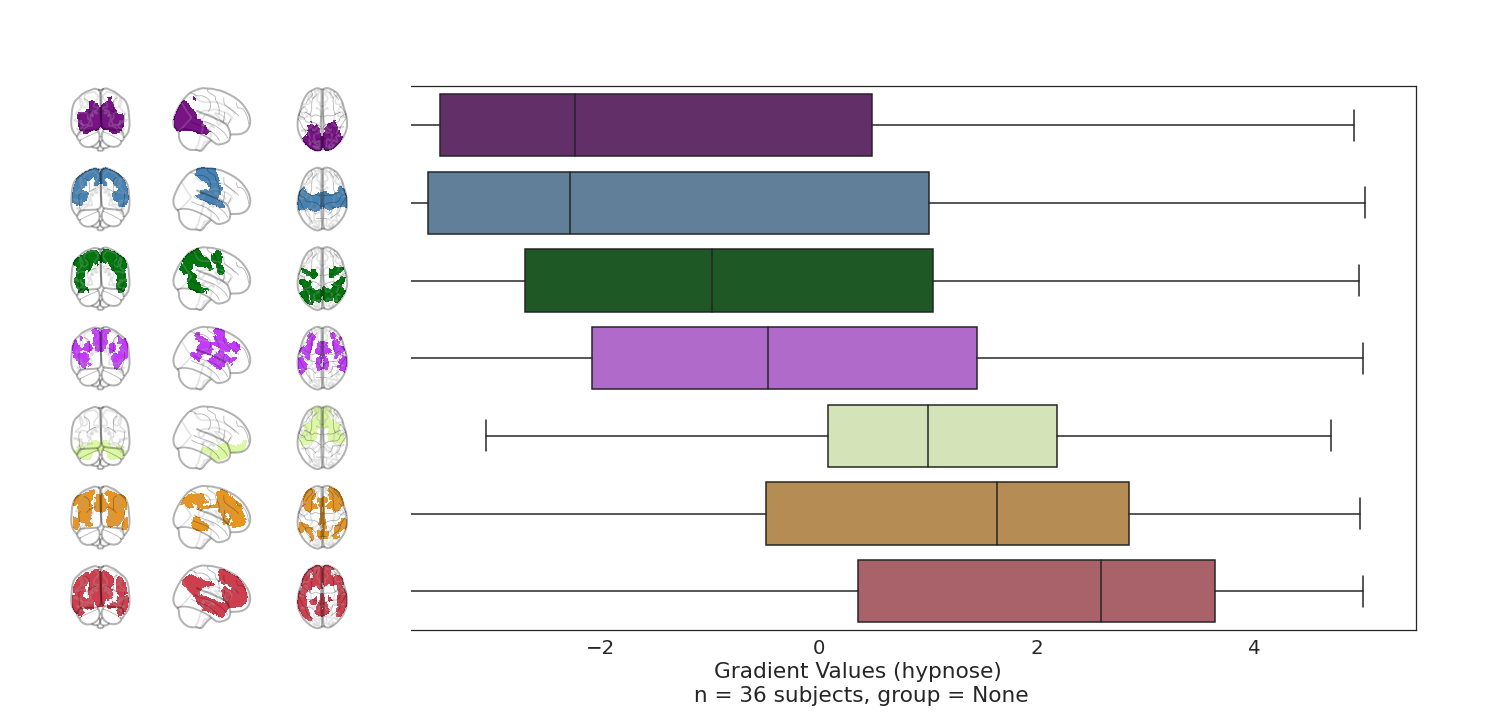

In [18]:
plot_gradients_yeo('hypnose')

In [19]:
yeo_infos

,Network Order,Network Name,colors
0,1,Visual,purple
1,2,Somatomotor,blue
2,3,Dorsal Attention,green
3,4,Salience / Ventral Attention,violet
4,5,Limbic,cream
5,6,Control,orange
6,7,Default,red
